In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import scipy.stats
from IPython.display import Video, display, HTML
import re

sns.set()


def gethighest(vals, prefix="logall_"):
        m = np.argmax([int(re.search(f'{prefix}(\d+)', val).group(1)) for val in vals])
        return vals[m]

def read_csvx(path, *args, **kwargs):
    try:
        return pd.read_csv(str(path) +'.gz', *args, **kwargs)
    except Exception as e:
        return pd.read_csv(str(path), *args, **kwargs)

        
def readparams(file):
    params = {} 
    with open(file) as f:
        for line in f:
            line = line[:-1]  # remove \n
            if not line or line.startswith('#') or line.startswith('import'):
                continue
            key, val = line.split('=')
            if val.lower() == 'true' or val.lower() == 'false':
                params[key] = val.lower() == 'true'
            else:
                try:
                    params[key] = float(val)
                except ValueError:
                    params[key] = val
    return params

In [30]:
params = []
prefix = '/home/pecoffet/remoterobo'

paths = sorted([]
                  + glob.glob(f"{prefix}/logs/lionscross/*/*/*/*/rep00/", recursive=True)
                  )
#paths = sorted(glob.glob(f"{prefix}/logs/lions-nvar-*-2019-06-*/**/rep00/", recursive=True))
for path in paths:
    print(path)
    try:
        logall = read_csvx(gethighest(glob.glob(path + 'logall*')), delimiter="\t")
    except Exception as e:
        print(e)
        continue
    curparam = readparams(glob.glob(path + 'properties*')[0])
    logall.query(f'nbOnOpp == {curparam["nOpti"]}')["curCoopNoCoef"].mean()
    nmod = logall['nbOnOpp'].mode()[0]
    coopopti = np.nanmean(logall.query(f"nbOnOpp == {curparam['nOpti']}")["curCoopNoCoef"])
    if np.isnan(coopopti):  # WARNING, bold choice !
        coopopti = 0
    coopmod =  np.nanmean(logall.query(f'nbOnOpp == {nmod}')["curCoopNoCoef"].mean())
    params.append({'path':path, 'params':curparam, 'coopopti': coopopti, 'coopmod': coopmod})



/home/pecoffet/remoterobo/logs/lionscross/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-06-1254/lion_megabig/o60/run_01/rep00/
/home/pecoffet/remoterobo/logs/lionscross/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-06-1254/lion_megabig/o60/run_02/rep00/
/home/pecoffet/remoterobo/logs/lionscross/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-06-1254/lion_megabig/o60/run_03/rep00/
/home/pecoffet/remoterobo/logs/lionscross/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-06-1254/lion_megabig/o60/run_04/rep00/
/home/pecoffet/remoterobo/logs/lionscross/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-06-1254/lion_megabig/o60/run_05/rep00/
/home/pecoffet/remoterobo/logs/lionscross/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-06-1254/lion_megabig/o60/run_06/rep00/
/home/pecoffet/remoterobo/logs/lionscross/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-06-1254/lion_megabig/o60/run_07/rep00/
/home/pecoffet/remoterobo/logs/lionscross/lions-work-tol0.2-pop100-fa

/home/pecoffet/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


/home/pecoffet/remoterobo/logs/lionscross/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-06-1454/lion_megabig/o10/run_02/rep00/
/home/pecoffet/remoterobo/logs/lionscross/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-06-1454/lion_megabig/o10/run_03/rep00/
/home/pecoffet/remoterobo/logs/lionscross/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-06-1454/lion_megabig/o10/run_04/rep00/
/home/pecoffet/remoterobo/logs/lionscross/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-06-1454/lion_megabig/o10/run_05/rep00/
/home/pecoffet/remoterobo/logs/lionscross/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-06-1454/lion_megabig/o10/run_06/rep00/
/home/pecoffet/remoterobo/logs/lionscross/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-06-1454/lion_megabig/o10/run_07/rep00/
/home/pecoffet/remoterobo/logs/lionscross/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-06-1454/lion_megabig/o10/run_08/rep00/
/home/pecoffet/remoterobo/logs/lionscross/lions-work-tol0.2-pop100-fa

In [8]:
diffkeys = set()
missingkeys = set()
for i in range(len(params)):
    for key in params[i]['params'].keys():
        try:
            if any(params[j]['params'][key] != params[i]['params'][key] for j in range(0, len(params) - 1)):
                diffkeys.add(key)
        except KeyError:
            missingkeys.add(key)

In [9]:
excluded = ['gSeed', 'gLogFilename', 'path']
processed = []
for elem in params:
    param = elem['params']
    ess = param['meanA'] / param['nOpti']
    so = param['meanA'] + param['b'] / float(param['nOpti'])
    outdict = {'coopopti': (elem['coopopti'] - ess) / (so - ess) , 'truecoopopti': elem['coopopti'],
               'coopmod': (elem['coopmod'] - ess) / (so - ess) , 'truecoopmod': elem['coopmod']}
    for key in diffkeys:
        if key in excluded: continue
        outdict[key] = elem['params'][key]
    processed.append(outdict)
    for key in missingkeys:
        if key in excluded: continue
        outdict[key] = elem['params'].get(key, False)
df = pd.DataFrame(processed)
normalized_df=(df-df.mean())/df.std()

In [10]:
df

,coopmod,coopopti,gNbOfPhysicalObjects,gRandomSeed,nOpti,nTolerance,takeVideo,truecoopmod,truecoopopti
0,0.829634,0.829634,60.0,-1.529695e+09,2.0,0.2,True,8.722252e+00,8.722252e+00
1,-0.168664,-0.168664,60.0,-1.529709e+09,2.0,0.2,True,1.235019e+00,1.235019e+00
2,-0.089245,-0.089245,60.0,-1.529722e+09,2.0,0.2,True,1.830663e+00,1.830663e+00
3,-0.025027,-0.025027,60.0,-1.529728e+09,2.0,0.2,True,2.312297e+00,2.312297e+00
4,0.380983,0.380983,60.0,-1.529729e+09,2.0,0.2,True,5.357375e+00,5.357375e+00
5,-0.133827,-0.133827,60.0,-1.529728e+09,2.0,0.2,True,1.496298e+00,1.496298e+00
6,0.319770,0.319770,60.0,-3.607232e+08,2.0,0.2,True,4.898275e+00,4.898275e+00
7,0.656965,0.656965,60.0,-3.607232e+08,2.0,0.2,True,7.427235e+00,7.427235e+00
8,0.997578,NaN,10.0,1.395472e+09,2.0,0.2,True,9.981835e+00,NaN
9,-0.280251,NaN,10.0,1.395482e+09,2.0,0.2,True,3.981161e-01,NaN


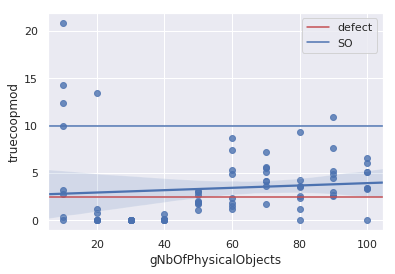

In [27]:
sns.regplot(x='gNbOfPhysicalObjects', y='truecoopmod', data=df.query('nOpti == 2 and nTolerance == 0.2'))
plt.axhline(2.5, label='defect', c='r')
plt.axhline(10, label='SO', c='b')
plt.legend()

In [18]:
import statsmodels.formula.api as sm

In [19]:
#normalized_df['nbRobots'] = normalized_df['gInitialNumberOfRobots']
normalized_df['nbObj'] = normalized_df['gNbOfPhysicalObjects']

normalized_df

,coopmod,coopopti,gNbOfPhysicalObjects,gRandomSeed,nOpti,nTolerance,takeVideo,truecoopmod,truecoopopti,nbObj
0,0.645820,2.099387,0.275598,-1.282709,-0.751907,-0.329894,1.144904,1.209549,2.656346,0.275598
1,-0.526292,-0.683571,0.275598,-1.282720,-0.751907,-0.329894,1.144904,-0.381561,-0.311414,0.275598
2,-0.433045,-0.462174,0.275598,-1.282732,-0.751907,-0.329894,1.144904,-0.254981,-0.075315,0.275598
3,-0.357646,-0.283153,0.275598,-1.282738,-0.751907,-0.329894,1.144904,-0.152629,0.115593,0.275598
4,0.119055,0.848684,0.275598,-1.282738,-0.751907,-0.329894,1.144904,0.494480,1.322589,0.275598
5,-0.485390,-0.586455,0.275598,-1.282738,-0.751907,-0.329894,1.144904,-0.326037,-0.207849,0.275598
6,0.047184,0.678039,0.275598,-0.242076,-0.751907,-0.329894,1.144904,0.396917,1.140613,0.275598
7,0.443088,1.618038,0.275598,-0.242076,-0.751907,-0.329894,1.144904,0.934346,2.143033,0.275598
8,0.843005,NaN,-1.456734,1.321309,-0.751907,-0.329894,1.144904,1.477223,NaN,-1.456734
9,-0.657308,NaN,-1.456734,1.321318,-0.751907,-0.329894,1.144904,-0.559411,NaN,-1.456734


In [22]:
result = sm.ols(formula="coopopti ~ nbObj + nTolerance + nOpti", data=normalized_df).fit()

In [23]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               coopopti   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     4.520
Date:                Thu, 08 Aug 2019   Prob (F-statistic):            0.00447
Time:                        11:34:16   Log-Likelihood:                -236.88
No. Observations:                 172   AIC:                             481.8
Df Residuals:                     168   BIC:                             494.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0183      0.080     -0.230      0.819      -0.176       0.139
nbObj          0.2597      0.088      2.944      0.004       0.086       0.434
nTolerance     0.1244      0.102      1.224      0.223      -0.076       0.325
nOpti          0.2502      0.087      2.879      0.005       0.079       0.422
==============================================================================
Omnibus:                       78.391   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              267.835
Skew:                           1.835   Prob(JB):                     6.93e-59
Kurtosis:                       7.889   Cond. No.                         1.78
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
df

,coopmod,coopopti,gNbOfPhysicalObjects,gRandomSeed,nOpti,takeVideo,truecoopmod,truecoopopti
0,0.829634,0.829634,60.0,-1.529695e+09,2.0,True,8.722252e+00,8.722252
1,-0.168664,-0.168664,60.0,-1.529709e+09,2.0,True,1.235019e+00,1.235019
2,-0.089245,-0.089245,60.0,-1.529722e+09,2.0,True,1.830663e+00,1.830663
3,-0.025027,-0.025027,60.0,-1.529728e+09,2.0,True,2.312297e+00,2.312297
4,0.380983,0.380983,60.0,-1.529729e+09,2.0,True,5.357375e+00,5.357375
5,-0.133827,-0.133827,60.0,-1.529728e+09,2.0,True,1.496298e+00,1.496298
6,0.319770,0.319770,60.0,-3.607232e+08,2.0,True,4.898275e+00,4.898275
7,0.656965,0.656965,60.0,-3.607232e+08,2.0,True,7.427235e+00,7.427235
8,0.997578,NaN,10.0,1.395472e+09,2.0,True,9.981835e+00,NaN
9,-0.280251,NaN,10.0,1.395482e+09,2.0,True,3.981161e-01,NaN
